#XAI ANALYSIS ON MISCLASSIFIED PATTERNS

In [ ]:
!git clone https://github.com/Marigra98/Turing-Dataset

Cloning into 'Turing-Dataset'...
remote: Enumerating objects: 5024, done.
remote: Counting objects: 100% (633/633), done.
remote: Compressing objects: 100% (598/598), done.
remote: Total 5024 (delta 56), reused 560 (delta 35), pack-reused 4391
Receiving objects: 100% (5024/5024), 349.88 MiB | 17.15 MiB/s, done.
Resolving deltas: 100% (587/587), done.


In [ ]:
import torch
from torch import nn

torch.__version__

'1.13.1+cu116'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import requests
import zipfile
from pathlib import Path

In [ ]:
import random
from PIL import Image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# load of the trained model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2), 

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(128*1*1, 5),
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.softmax(self.linear_block(x),dim=1)
        return x
        
CNN=Net()
CNN.load_state_dict(torch.load('/content/Turing-Dataset/CNN_trained.pt',map_location=torch.device('cpu')))
CNN.eval();



---


Names of the used classes
[Homog, Lab, Mix S-S, R S, R S&W]


---



We chose 3 examples from the set of mislabeled patterns

In [ ]:
#Function to put the channel in the first position
def preprocessing(M):
    height, width = M.shape
    M=M.reshape(height, width, 1)
   
    M=np.transpose(M,(2,0,1))
   
    return M

In [ ]:
#number of total examples analyzed
max = 3

# Label of all type of patterns inside our model
name_confronto = ['Homog', 'Lab', 'Mix S-S', 'R S', 'R S&W']

# Correct string type labels of the example we will analyze
name = ['Lab', 'Mix S-S', 'R S&W']
# Correct int type labels of the example we will analyze
name_num_classe_right=[1,2,4]

# Predicted string type labels of the example we will analyze
name_predict = ['R S&W', 'Lab', 'R S']
# Predicted int type labels of the example we will analyze
name_num_classe=[4,1,3]

In [ ]:
#Saving the patterns in x_miss and the relative labels both as numbers in  y_miss and strings in y_miss_name
import os, sys
import scipy.io

x_miss=np.empty((0,99,99))
y_miss=np.empty((0))
y_miss_name=np.empty((0))


path_train= '/content/Turing-Dataset/DATASET.m/Validation'

#Definition, only for a mathematical checking, of the value of the parameters B and C for each pattern
path_xai_miss=['L,B=48,C=5.mat','MSS,B=50.4348,C=5.5556.mat',
               'RSW,B=37.1429,C=4.6667.mat']


for i in range(3):
    #File path
    file_name=path_train+'/'+path_xai_miss[i]
    mat = scipy.io.loadmat(file_name)
    M=mat.get('M')
    label=mat.get('pattern')
    label=label[0]

    #Loading of the patterns in x_miss 
    M=preprocessing(M)
    x_miss=np.vstack((x_miss,M))

    #Loading of the numerical labels in y_miss and of the string labels in y_miss_name 
    if label=='homogeneous':
      y_miss=np.append(y_miss,0)
      y_miss_name=np.append(y_miss_name,'Homog')

    if label=='labyrinths':
      y_miss=np.append(y_miss,1)
      y_miss_name=np.append(y_miss_name,'Lab')
        
    if label=='mixed spots-stripes':
      y_miss=np.append(y_miss,2)
      y_miss_name=np.append(y_miss_name,'Mix s-s')

    if label=='reversed spots':
      y_miss=np.append(y_miss,3)
      y_miss_name=np.append(y_miss_name,'R S')

    if label=='reversed spots & worms':
      y_miss=np.append(y_miss,4)
      y_miss_name=np.append(y_miss_name,'R S&W')

In [ ]:
# We defined image_vet to allocate all the patterns in x_miss in order to plot the images of the patterns without reshaped them every time
image_vet = np.empty((max,1,99,99))

for idx in range(0,max):
  image_temp = x_miss[idx :idx +1]
  image_vet[idx,:,:,:]=image_temp

In [ ]:
# We saved alle the predicted probability for each chosen pattern in pred_vet
pred_vet = np.empty((max,5))
for idx in range(0,max):
  input = image_vet[idx,:].transpose(1,2,0)
  pred = CNN(torch.tensor(input).permute(2,0,1).unsqueeze(0).float())
  pred_vet[idx,:]= pred.detach().numpy()[0][:]

In [ ]:
pred_vet

array([[0.02530704, 0.34799293, 0.04470528, 0.03164674, 0.5503481 ],
       [0.0346458 , 0.64390725, 0.22680342, 0.03097449, 0.06366908],
       [0.03754386, 0.03480776, 0.03303233, 0.76434177, 0.1302743 ]])

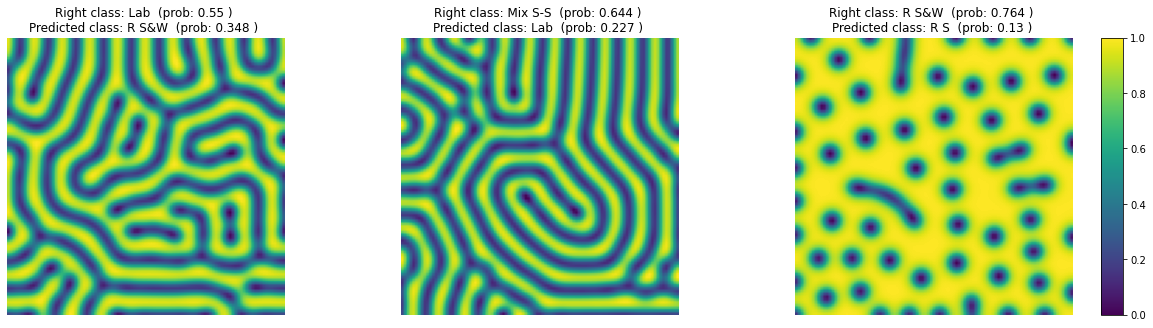

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


#Print the patterns chosen for the analysis with the predicted class and the right class with their respective probabilities
plt.figure(figsize=(20, 20))
for idx in range(0,max):
  a = name_num_classe[idx]
  b = name_num_classe_right[idx]
  ax = plt.subplot(1,max,1+idx)
  plot = ax.imshow(image_vet[idx,:,:,:].reshape(99,99),cmap='viridis')
  divider = make_axes_locatable(ax)
  plt.axis('off');
  plt.title('Right class: '+ name[idx]+ '  (prob: '+str(round(pred_vet[idx][a],3))+ ' ) '+'\n'+'Predicted class: '+ name_predict[idx] + '  (prob: '+str(round(pred_vet[idx][b],3))+ ' ) ') 
  cax = divider.append_axes("right", size="8%", pad=0.4)
  cbar=plt.colorbar(plot, cax=cax)
  if idx != max-1:
    cbar.remove()





---



---



---



---



---



#***XAI***

In [ ]:
!git clone https://github.com/francescanaretto/XAI-course_2021.git

Cloning into 'XAI-course_2021'...
remote: Enumerating objects: 3888, done.
remote: Counting objects: 100% (1335/1335), done.
remote: Compressing objects: 100% (1319/1319), done.
remote: Total 3888 (delta 21), reused 1325 (delta 16), pack-reused 2553
Receiving objects: 100% (3888/3888), 1005.68 MiB | 29.71 MiB/s, done.
Resolving deltas: 100% (311/311), done.
Updating files: 100% (3176/3176), done.


In [ ]:
cd XAI-course_2021/Images/

/content/XAI-course_2021/Images




---



---



##LIME




In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=1adaa21f9486027235385057b41ce38356feca47603693ec006e5110faa93026
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


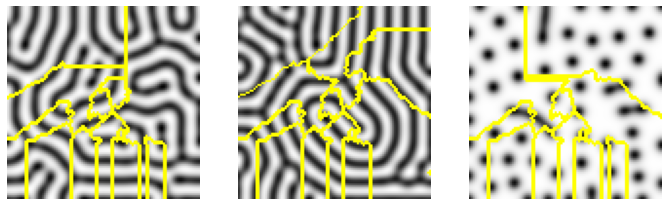

In [ ]:
from skimage.segmentation import quickshift, mark_boundaries
from skimage.color import gray2rgb


image = np.zeros(shape=(max, 99,99,3))
for idx in range(0,max):  
  image[idx,:] = gray2rgb(image_vet[idx,:].astype(int))


#First we need to define the segmentation function to use
def segmentation_fn(image):
    return quickshift(image, kernel_size=9, max_dist=9)

#Plot of the segmented images
plt.figure(figsize=(20, 15))
for idx in range(0,max):
  ax=plt.subplot(1,5,idx+1)
  plot=ax.imshow(mark_boundaries(x_miss[idx,:],segmentation_fn(image[idx,:])))
  plt.axis('off');

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

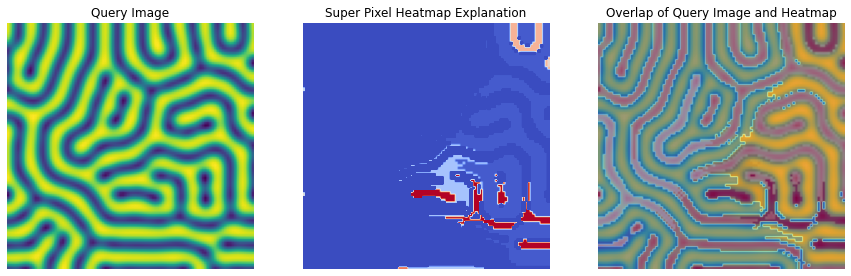

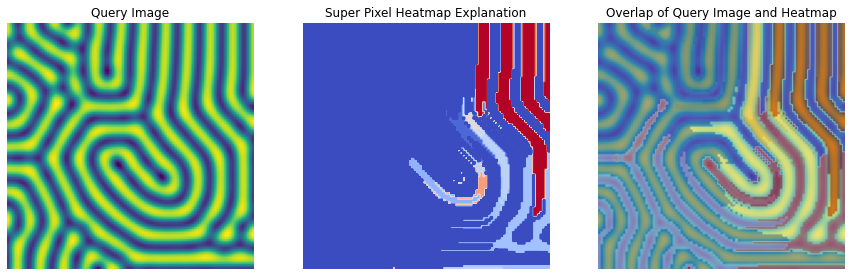

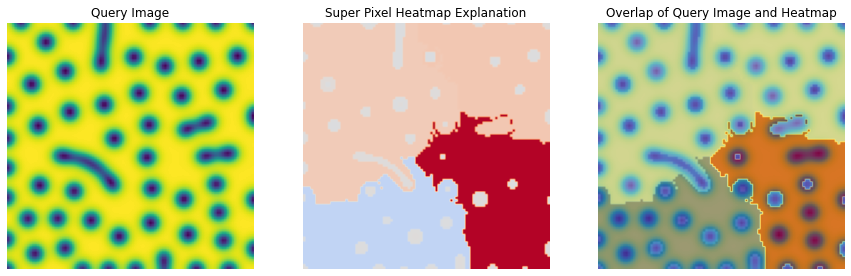

In [ ]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb, gray2rgb, rgb2gray

# Create the Explainer
lm = LimeXAIImageExplainer(CNN)

# Fit the Explainer
lm.fit()

# Create custom classifier function if not predict 
def classifier_fn(images):
    images = torch.tensor(rgb2gray(images).reshape(-1,1,99,99)).float()
    return np.argmax(CNN(images).detach().numpy(),axis=1).reshape(-1,1)


# Explain an Instance ( we use 10000 samples )
explanation = np.empty((0))
lime_score = np.zeros(shape=(max,99,99))
for idx in range(0,max):
  explanation = np.append(explanation,lm.explain(gray2rgb(x_miss[idx,:]), classifier_fn, segmentation_fn, num_samples=10000))
  lime_score[idx,:]=explanation[idx].heatmap


# Plot the results
for idx in range(0,max):
  lm.plot_lime_values(x_miss[idx,:], explanation[idx])

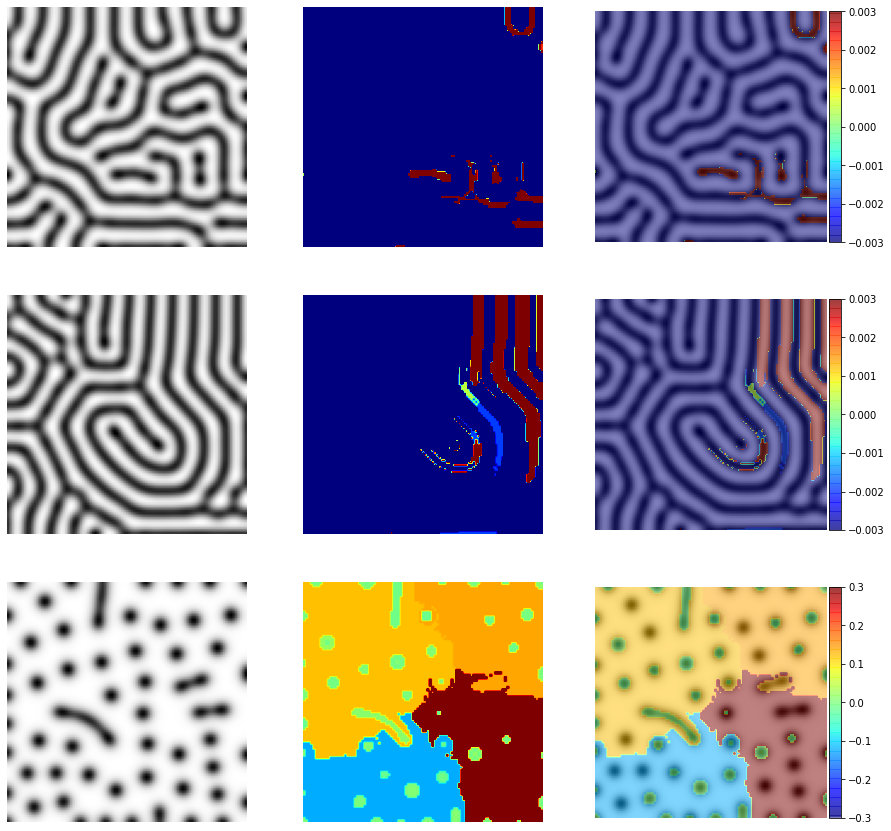

In [ ]:
vmin = [-0.003,-0.003,-0.3]
vmax = [0.003,0.003,0.3]
plt.figure(figsize=(15, 15))
for idx in range(0,max):
  ax = plt.subplot(3,3,1+idx*3)
  plot = ax.imshow(x_miss[idx,:,:],cmap='gray')
  plt.axis('off');

  ax = plt.subplot(3,3,2+idx*3)
  plot = ax.imshow(lime_score[idx,:,:],cmap='jet', vmin =vmin[idx], vmax=vmax[idx])
  plt.axis('off');

  ax = plt.subplot(3,3,3+idx*3)
  plot2 = ax.imshow(x_miss[idx,:,:],cmap='gray')
  plot = ax.imshow(lime_score[idx,:,:],cmap='jet',alpha=0.5, vmin =vmin[idx], vmax=vmax[idx])
  divider = make_axes_locatable(ax)
  plt.axis('off');
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar=plt.colorbar(plot, cax=cax)

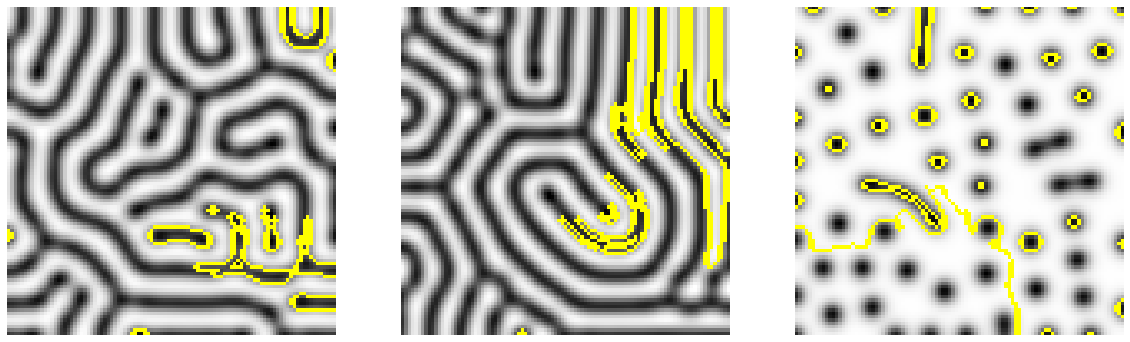

In [ ]:
from skimage.segmentation import mark_boundaries


plt.figure(figsize=(20, 15))
img_boundry = np.zeros(shape=(max,99,99,3))
for idx in range(0,max):
  ax=plt.subplot(1,max,1+idx)
  temp, mask = explanation[idx].get_image_and_mask(explanation[idx].top_labels[0])
  img_boundry[idx,:] = mark_boundaries(temp, mask)
  plot=ax.imshow(img_boundry[idx,:])
  plt.axis('off');

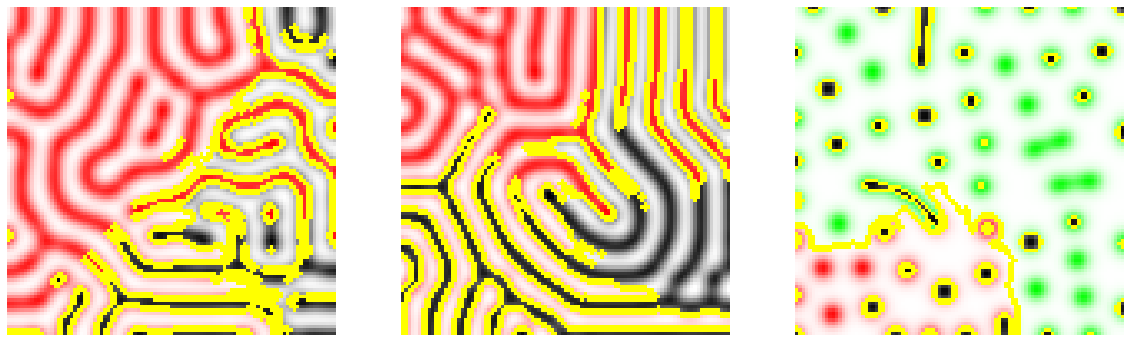

In [ ]:
plt.figure(figsize=(20, 15))
img_boundry_FALSE = np.zeros(shape=(max,99,99,3))
for idx in range(0,max):
  ax=plt.subplot(1,max,1+idx)
  temp, mask = explanation[idx].get_image_and_mask(explanation[idx].top_labels[0], positive_only=False)
  img_boundry_FALSE[idx,:] = mark_boundaries(temp, mask)
  plot=ax.imshow(img_boundry_FALSE[idx,:])
  plt.axis('off');

In [ ]:
# Creation of the metric for the removal of the most significant pixels
from xailib.metrics.insertiondeletion import ImageInsDel
import torch

def predict(images):
    return CNN(torch.tensor(images.reshape(1,1,99,99)).float()).detach().numpy()

step = 180
mode = 'del'
metric_REMUVED = ImageInsDel(predict, mode, step, torch.zeros_like)

In [ ]:
from sklearn.metrics import auc

In [ ]:
from scipy.ndimage.filters import gaussian_filter
CH = 1
def gkern(klen, nsig):
    """Returns a Gaussian kernel array.
    Convolution with it results in image blurring."""
    inp = np.zeros((klen, klen))
    inp[klen//2, klen//2] = 1
    k = gaussian_filter(inp, nsig)
    kern = np.zeros((CH, CH, klen, klen))
    for i in range(CH):
        kern[i, i] = k
    return torch.from_numpy(kern.astype('float32'))

# Function that blurs input image
def blur(image, klen=11, ksig=5):

    kern = gkern(klen, ksig)
    image = torch.tensor(np.expand_dims(image, 0)).float()
    return nn.functional.conv2d(image, kern, padding=klen//2)[0,:]

In [ ]:
# Creation of the metric for the addition of the most significant pixels
from xailib.metrics.insertiondeletion import ImageInsDel


def predict(images):
    return CNN(torch.tensor(images.reshape(1,1,99,99)).float()).detach().numpy()

step = 180
mode = 'ins'
metric_ADDED = ImageInsDel(predict, mode, step, blur)

Animations

In [ ]:
anim_lime_REM_tot = np.empty((0))
for ii in range(0,max):
  image = x_miss[ii:ii+1]
  [score,anim_lime_REM] = metric_REMUVED(image, 99, lime_score[ii,:], rgb=False, verbose=1)
  anim_lime_REM_tot = np.append(anim_lime_REM_tot, anim_lime_REM)

In [ ]:
anim_lime_REM_tot[0]

In [ ]:
anim_lime_REM_tot[1]

In [ ]:
anim_lime_REM_tot[2]

In [ ]:
anim_lime_ADD_tot = np.empty((0))
for ii in range(0,max):
  image = x_miss[ii:ii+1]
  [score,anim_lime_ADD] = metric_ADDED(image, 99, lime_score[ii,:], rgb=False, verbose=1)
  anim_lime_ADD_tot = np.append(anim_lime_ADD_tot, anim_lime_ADD)

In [ ]:
anim_lime_ADD_tot[0]

In [ ]:
anim_lime_ADD_tot[1]

In [ ]:
anim_lime_ADD_tot[2]



---



---



##RISE

In [ ]:
from xailib.explainers.rise_explainer import RiseXAIImageExplainer

class Rise_model_wrapper():
    def __init__(self, bb, input_size):
        self.model = bb
        self.input_size = input_size
        
    def predict(self, images):
        return self.model(torch.tensor(images).reshape(-1,1,99,99).float()).detach().numpy()
        

model = Rise_model_wrapper(CNN, (99,99))
rise = RiseXAIImageExplainer(model)

In [ ]:
N = 5000
s = 20
p1 = 0.5
rise.fit(N, s, p1)

#usefull for the comparison with the correct class
y_miss_right = [1,2,4]
#usefull for the comparison with the predicted class
y_miss_mistacken = [4,1,3]


sal = np.zeros(shape=(3,5,99,99))
rise_score = np.zeros(shape=(3,99,99))
for idx in range(0,max):
  sal[idx,:] = rise.explain(image_vet[idx,:].reshape(99,99,1))
  rise_score[idx,:] = sal[idx,int(y_miss_mistacken[idx])]

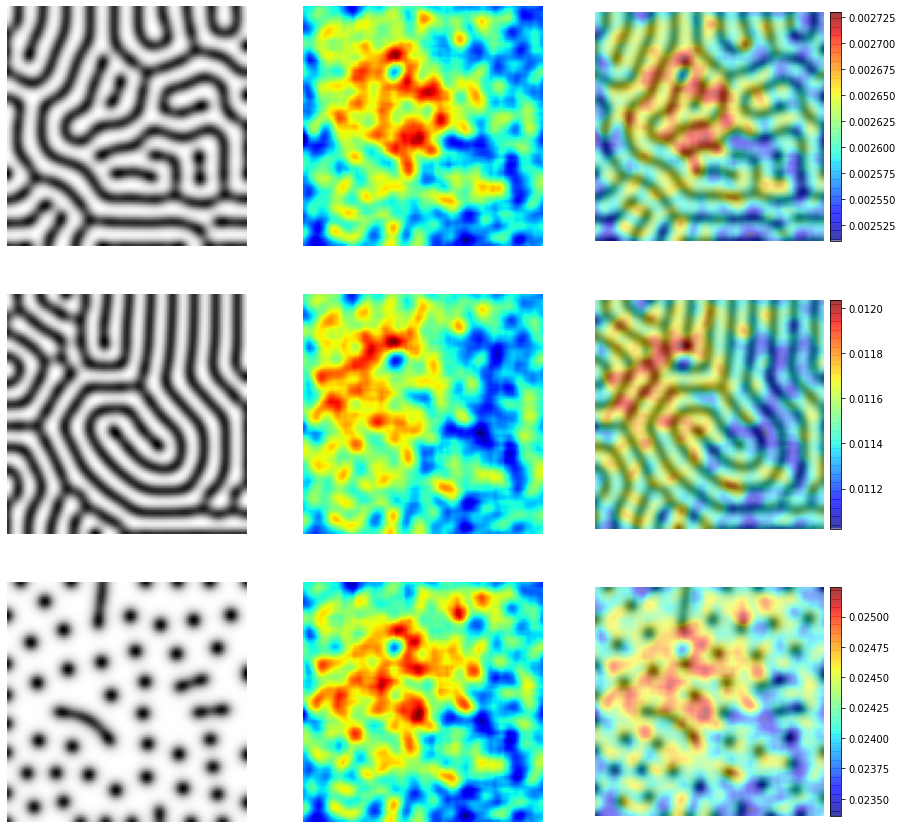

In [ ]:
vmin = [-0.001,-0.001,-0.001]
vmax = [0.001,0.001,0.001]
plt.figure(figsize=(15, 15))
for idx in range(0,max):
  ax = plt.subplot(3,3,1+idx*3)
  plot = ax.imshow(x_miss[idx,:,:],cmap='gray')
  plt.axis('off');

  ax = plt.subplot(3,3,2+idx*3)
  plot = ax.imshow(rise_score[idx,:,:],cmap='jet')
  plt.axis('off');

  ax = plt.subplot(3,3,3+idx*3)
  plot2 = ax.imshow(x_miss[idx,:,:],cmap='gray')
  plot = ax.imshow(rise_score[idx,:,:],cmap='jet',alpha=0.5)
  divider = make_axes_locatable(ax)
  plt.axis('off');
  cax = divider.append_axes("right", size="5%", pad=0.08)
  cbar=plt.colorbar(plot, cax=cax)

Animation

In [ ]:
anim_rise_REM_tot = np.empty((0))
for ii in range(0,max):
  image = x_miss[ii:ii+1]
  [score,anim_rise_REM] = metric_REMUVED(image, 99, rise_score[ii,:], rgb=False, verbose=1)
  anim_rise_REM_tot = np.append(anim_rise_REM_tot, anim_rise_REM)

In [ ]:
anim_rise_REM_tot[0]

In [ ]:
anim_rise_REM_tot[1]

In [ ]:
anim_rise_REM_tot[2]

In [ ]:
anim_rise_ADD_tot = np.empty((0))
for ii in range(0,max):
  image = x_miss[ii:ii+1]
  [score,anim_rise_ADD] = metric_ADDED(image, 99, rise_score[ii,:], rgb=False, verbose=1)
  anim_rise_ADD_tot = np.append(anim_rise_ADD_tot, anim_rise_ADD)

In [ ]:
anim_rise_ADD_tot[0]

In [ ]:
anim_rise_ADD_tot[1]

In [ ]:
anim_rise_ADD_tot[2]




---



---



##Integrad

In [ ]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create the Explainer
ig = IntgradImageExplainer(CNN)

# Fit the Explainer
ig.fit()

# Preprocessing function: function that takes as input an image and return the correct format for the black box
def preprocessing(image):
    return torch.tensor(image).float()

# Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    return CNN(image.unsqueeze(0))

# Explain an Instance
intgrad_pt_score = np.empty((3,5,99,99))
for idx in range(0,max):
  for cl in range(0,5):
    xx = ig.explain(image_vet[idx,:], cl, 'half', preprocessing, predict, model_type='pytorch').reshape(99,99)
    intgrad_pt_score[idx,cl,:] = xx

MISSED in VALIDATION


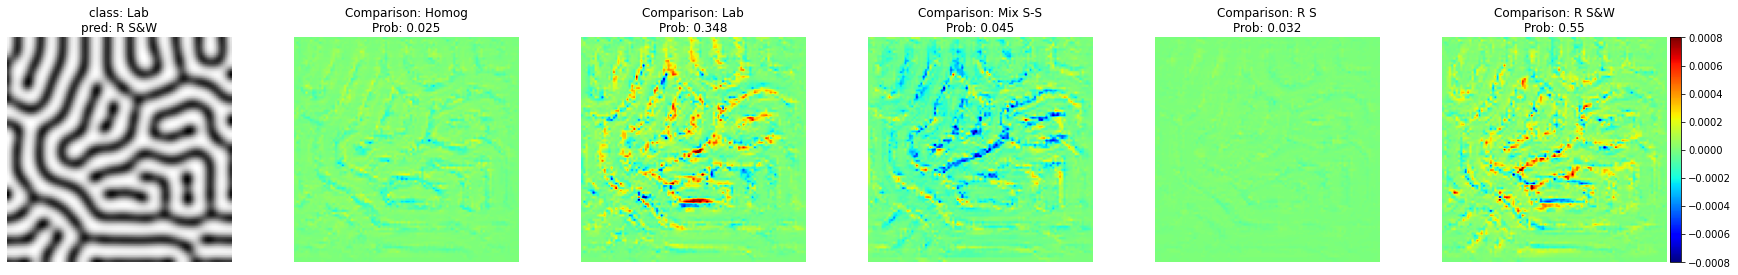

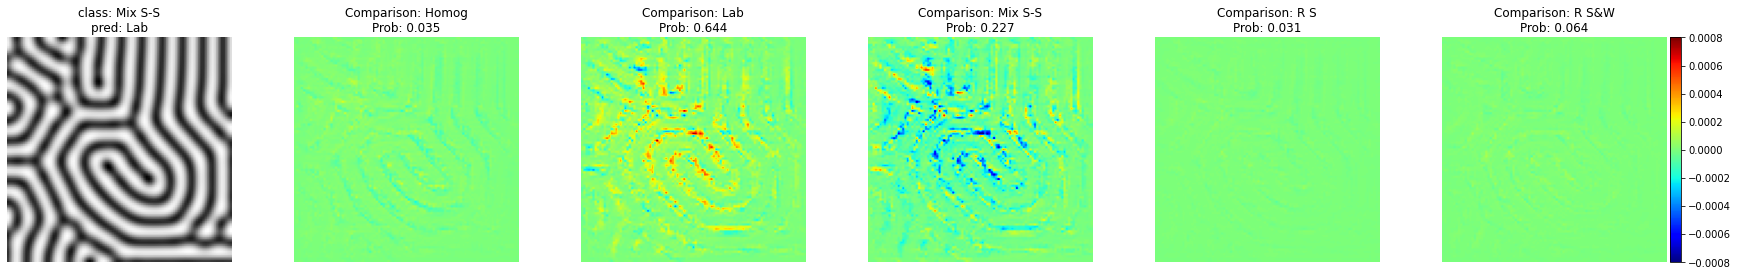

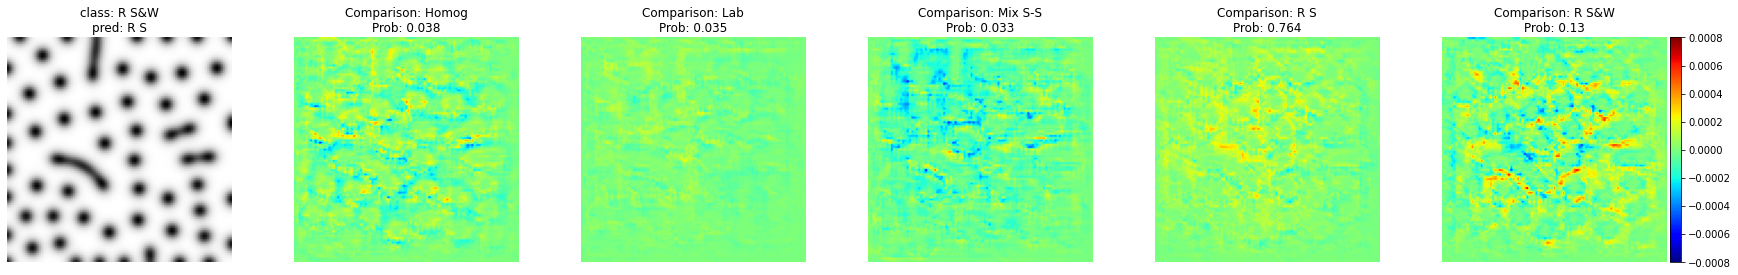

In [ ]:
print('MISSED in VALIDATION')
for idx in range(0,3):
  plt.figure(figsize=(30, 15))
  ax = plt.subplot(1,6,1)
  plt.title('class: '+ name[idx]+'\n'+'pred: '+ name_predict[idx])
  plot=ax.imshow(image_vet[idx,:].reshape(99,99),cmap='gray')
  divider = make_axes_locatable(ax)
  plt.axis('off');
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar=plt.colorbar(plot, cax=cax)
  cbar.remove()
  

  for a in range(0,5):
    ax = plt.subplot(1,6,2+a)
    plt.title('Comparison: '+ name_confronto[a]+'\n'+ 'Prob: ' + str(round(pred_vet[idx,a],3)))
    plot=ax.imshow(intgrad_pt_score[idx,a,:,:], cmap='jet', vmin=-0.0008, vmax=0.0008)
    divider = make_axes_locatable(ax)
    plt.axis('off');
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=plt.colorbar(plot, cax=cax)
    if a != 4:
      cbar.remove()

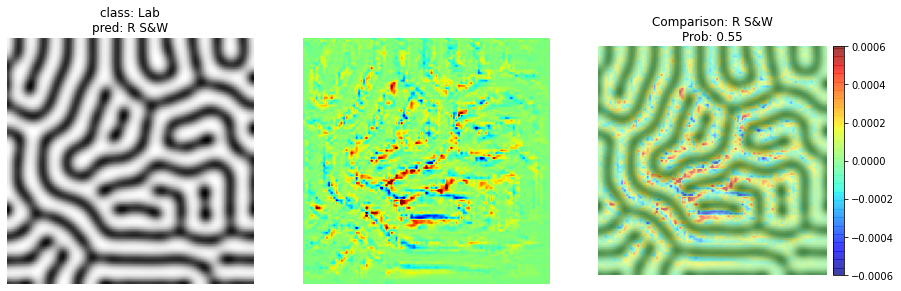

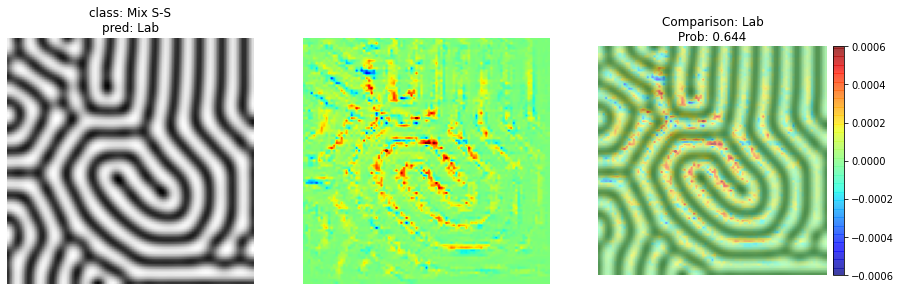

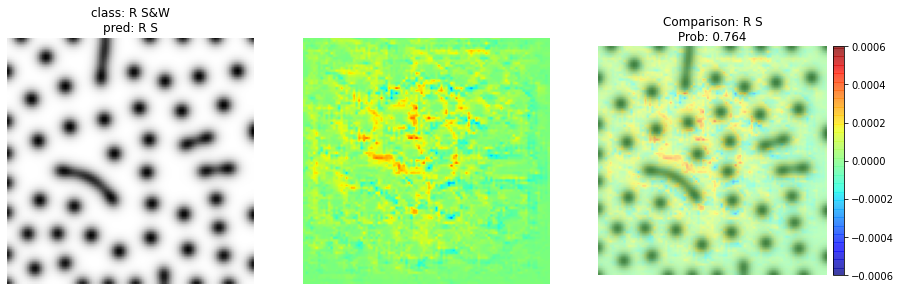

In [ ]:
for idx in range(0,3):
  plt.figure(figsize=(15, 8))
  ax = plt.subplot(1,3,1)
  plt.title('class: '+ name[idx]+'\n'+'pred: '+ name_predict[idx])
  plot=ax.imshow(image_vet[idx,:].reshape(99,99),cmap='gray')
  plt.axis('off');
  
  

  a = name_num_classe[idx]
  ax = plt.subplot(1,3,2)
  plot=ax.imshow(intgrad_pt_score[idx,a,:],cmap='jet', vmin=-0.0006, vmax=0.0006)
  plt.axis('off');
  

  ax = plt.subplot(1,3,3)
  plt.title('Comparison: '+ name_confronto[a]+'\n'+ 'Prob: ' + str(round(pred_vet[idx,a],3)))
  plot=ax.imshow(image_vet[idx,:].reshape(99,99),cmap='gray')
  plot1=ax.imshow(intgrad_pt_score[idx,a,:],cmap='jet',alpha=0.5, vmin=-0.0006, vmax=0.0006)
  divider = make_axes_locatable(ax)
  plt.axis('off');
  cax = divider.append_axes("right", size="5%", pad=0.08)
  cbar=plt.colorbar(plot1, cax=cax)

Animations

In [ ]:
name_num_classe=[4,1,3]

scores=np.empty((0,56))
anim_integrad_REM=np.empty((0))
for idx in range(0,max):
  classe = name_num_classe[idx]
  [scores_temp,anim_temp] = metric_REMUVED(image_vet[idx,:], 99, intgrad_pt_score[idx,classe,:], rgb=False, verbose=1)
  scores= np.vstack((scores,scores_temp))
  anim_integrad_REM= np.append(anim_integrad_REM,anim_temp)

In [ ]:
anim_integrad_REM[0]

In [ ]:
anim_integrad_REM[1]

In [ ]:
anim_integrad_REM[2]

In [ ]:
scores=np.empty((0,56))
anim_integrad_ADD=np.empty((0))
for idx in range(0,max):
  classe = name_num_classe[idx]
  [scores_temp,anim_temp] = metric_ADDED(image_vet[idx,:], 99, intgrad_pt_score[idx,classe,:], rgb=False, verbose=1)
  scores= np.vstack((scores,scores_temp))
  anim_integrad_ADD= np.append(anim_integrad_ADD,anim_temp)

In [ ]:
anim_integrad_ADD[0]

In [ ]:
anim_integrad_ADD[1]

In [ ]:
anim_integrad_ADD[2]

---

---

##GradCAM


In [ ]:
!pip install ttach

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from xailib.explainers.gradcam_explainer import GradCAMImageExplainer

# Create the Explainer
explainer = GradCAMImageExplainer(CNN)

# Fit the Explainer
explainer.fit([list(CNN.modules())[-15]])

# Explain an Instance
gradcam_pt_score = np.zeros(shape=(3,5,99,99))
attr = np.zeros(shape=(3,5,3,99,99))
for idx in range(0,max):
  for a in range(0,5):
    attr[idx,a,:] = explainer.explain(torch.tensor(x_miss[idx,:]).reshape(-1,1,99,99).float(), a, model_type='pytorch')
    gradcam_pt_score[idx,a,:] = attr[idx,a,0,:]

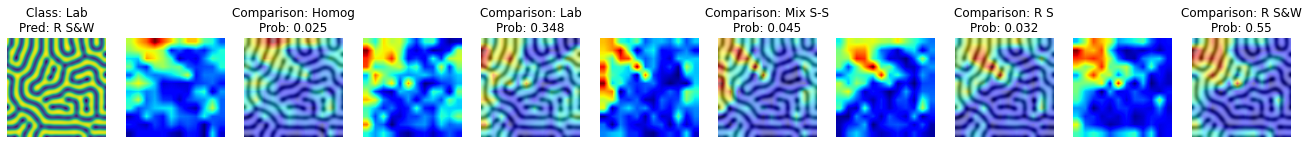

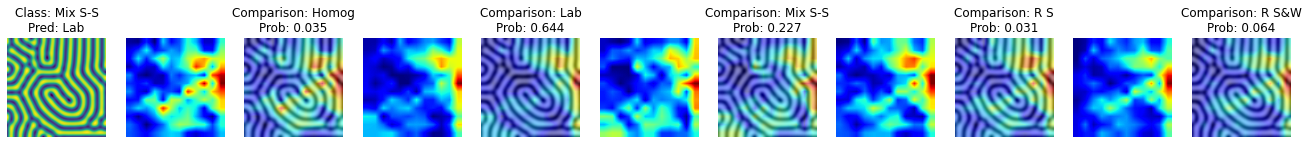

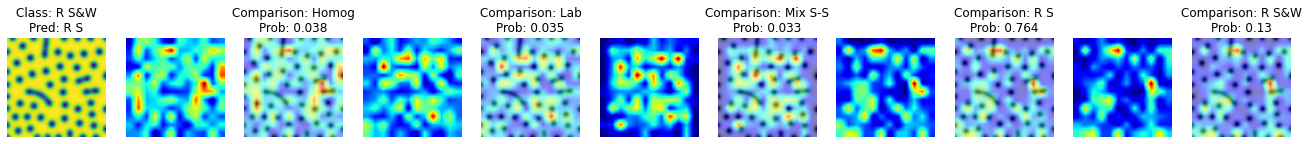

In [ ]:
for idx in range(0,3):
  plt.figure(figsize=(23, 15))
  ax = plt.subplot(1,11,1)
  plt.title('Class: '+ name[idx]+'\n'+'Pred: '+ name_predict[idx])
  plot=ax.imshow(image_vet[idx,:].reshape(99,99),cmap='viridis')
  plt.axis('off');
  
  

  for a in range(0,5):
    ax = plt.subplot(1,11,2+a*2)
    plot=ax.imshow(attr[idx,a,0,:],cmap='jet')
    plt.axis('off');
  

    ax = plt.subplot(1,11,3+a*2)
    plt.title('Comparison: '+ name_confronto[a]+'\n'+ 'Prob: ' + str(round(pred_vet[idx,a],3)))
    plot=ax.imshow(image_vet[idx,:].reshape(99,99),cmap='gray')
    plot1=ax.imshow(attr[idx,a,0,:],cmap='jet',alpha=0.5)
    plt.axis('off');
  

In [ ]:
#we recompute the explanation only on the predicted class
gradcam_pt_score1 = np.zeros(shape=(3,99,99))
attr1 = np.zeros(shape=(3,3,99,99))
for idx in range(0,max):
  a = name_num_classe[idx]
  attr1[idx,:] = explainer.explain(torch.tensor(image_vet[idx,:]).reshape(-1,1,99,99).float(), a, model_type='pytorch')
  gradcam_pt_score1[idx,:] = attr[idx,a,0,:]

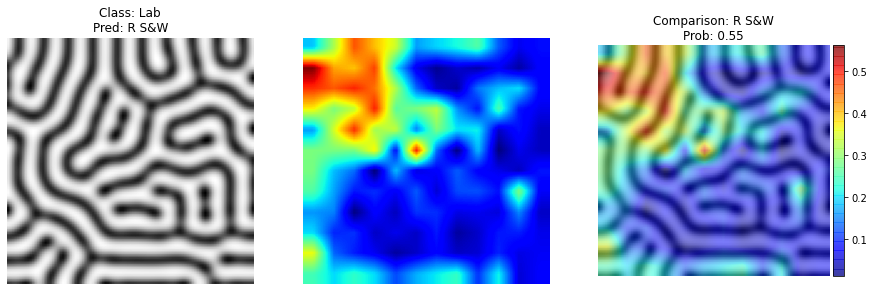

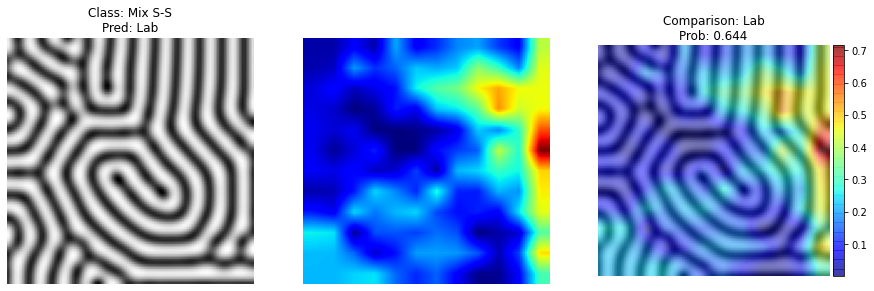

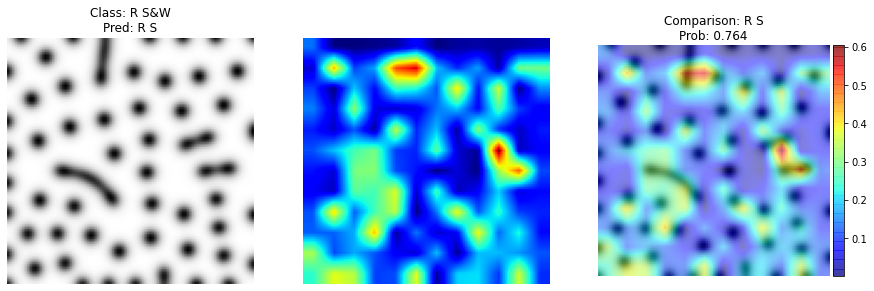

In [ ]:
for idx in range(0,3):
  plt.figure(figsize=(15, 8))
  ax = plt.subplot(1,3,1)
  plt.title('Class: '+ name[idx]+'\n'+'Pred: '+ name_predict[idx])
  plot=ax.imshow(image_vet[idx,:].reshape(99,99),cmap='gray')
  plt.axis('off');
  
  a = name_num_classe[idx]
  ax = plt.subplot(1,3,2)
  plot=ax.imshow(attr1[idx,0,:],cmap='jet')
  plt.axis('off');

  ax = plt.subplot(1,3,3)
  plt.title('Comparison: '+ name_confronto[a]+'\n'+ 'Prob: ' + str(round(pred_vet[idx][a],3)))
  plot=ax.imshow(image_vet[idx,:].reshape(99,99),cmap='gray')
  plot1=ax.imshow(attr1[idx,0,:],cmap='jet',alpha=0.5)
  divider = make_axes_locatable(ax)
  plt.axis('off');
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar=plt.colorbar(plot1, cax=cax)
  

Animations

In [ ]:
scores=np.zeros(shape=(3,5,56))
anim_GradCAM_REM=np.empty((0))
for idx in range(0,max):
  for cl in range(0,5):
    [scores_temp,anim_temp] = metric_REMUVED(image_vet[idx,:], 99, gradcam_pt_score[idx,cl,:], rgb=False, verbose=1)
    scores[idx,cl,:]= scores_temp
    anim_GradCAM_REM= np.append(anim_GradCAM_REM,anim_temp)

In [ ]:
anim_GradCAM_REM[4]

In [ ]:
anim_GradCAM_REM[6]

In [ ]:
anim_GradCAM_REM[13]

In [ ]:
scores=np.zeros(shape=(3,5,100))
anim_GradCAM_ADD=np.empty((0))
for idx in range(0,max):
  for cl in range(0,5):
    [scores_temp,anim_temp] = metric_ADDED(image_vet[idx,:], 99, gradcam_pt_score[idx,cl,:], rgb=False, verbose=1)
    scores[idx,cl,:]= scores_temp
    anim_GradCAM_ADD= np.append(anim_GradCAM_ADD,anim_temp)

In [ ]:
anim_GradCAM_ADD[4]

In [ ]:
anim_GradCAM_ADD[6]

In [ ]:
anim_GradCAM_ADD[13]



---
---


#COMPARISON AMONG ALL THE METHODS

Plot of all explanation maps

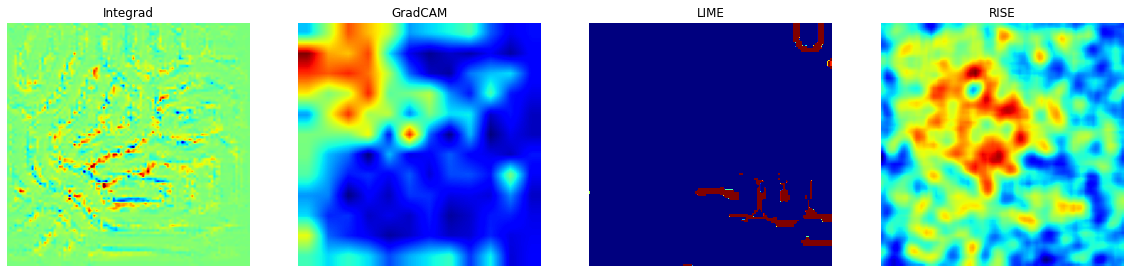

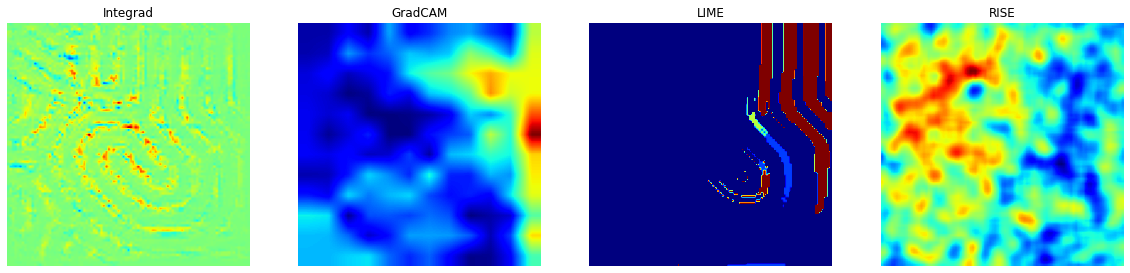

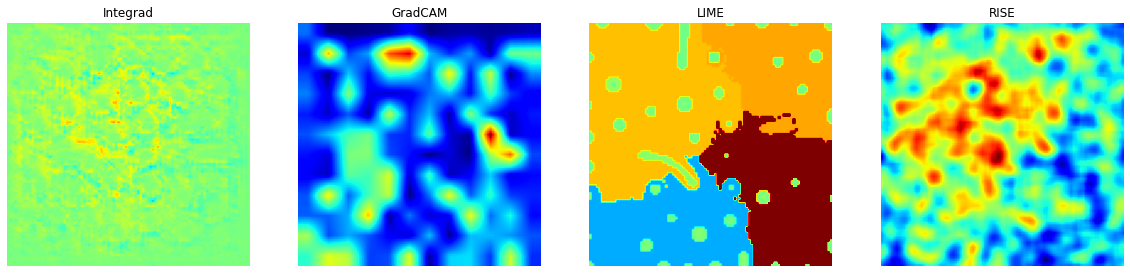

In [ ]:
vmin_lime = [-0.003,-0.003,-0.3]
vmax_lime = [0.003,0.003,0.3]


for ii in range(0,max):
  cl = name_num_classe[ii]
  methods = [intgrad_pt_score[ii,cl,:],gradcam_pt_score[ii,cl,:],lime_score[ii,:], rise_score[ii,:]]
  name_methods=['Integrad','GradCAM','LIME','RISE']
  F, ax = plt.subplots(1,4,figsize=(20,5))
  for i in range(4):
      ax[i].axis(False)
      if i ==2:
        ax[i].imshow(methods[i],cmap='jet', vmin = vmin_lime[ii], vmax = vmax_lime[ii])
      elif i==0:
        ax[i].imshow(methods[i],cmap='jet', vmin=-0.0008, vmax=0.0008)
      else:
        ax[i].imshow(methods[i],cmap='jet')
      ax[i].set_title(name_methods[i])

Plot of the methods' metrics for each analyzed pattern, for the pixel remotion

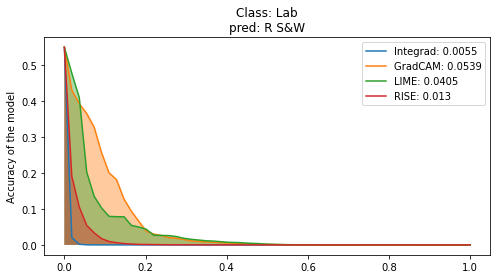

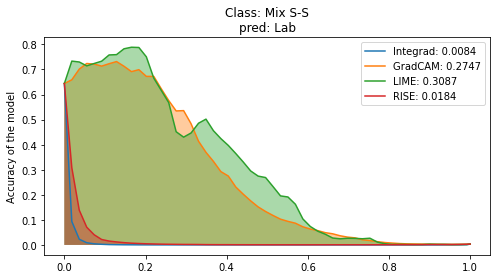

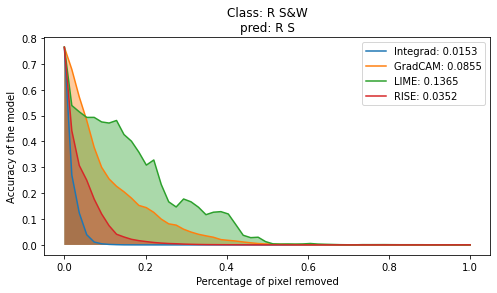

In [ ]:
from sklearn.metrics import auc
for ii in range(0,max):
  cl = name_num_classe[ii]
  image = x_miss[ii:ii+1]
  y_int = metric_REMUVED(image, 99, intgrad_pt_score[ii,cl,:], rgb=False)
  y_lime = metric_REMUVED(image, 99, lime_score[ii,:], rgb=False)
  y_rise = metric_REMUVED(image, 99, rise_score[ii,:], rgb=False)
  y_gradCAM = metric_REMUVED(image, 99, gradcam_pt_score[ii,cl,:], rgb=False)
  x = np.arange(len(y_lime))*step/(99*99)
  x[-1] = 1.0
  

  plt.figure(figsize=(8, 4))
  plt.title('Class: '+ name[ii] + '\n' + 'pred: '+ name_predict[ii])
  for nome, y in zip(['Integrad','GradCAM','LIME','RISE'],[y_int,y_gradCAM, y_lime,y_rise]):
      plt.plot(x, y, label=f'{nome}: {np.round(auc(x, y),4)}')
      plt.fill_between(x, y, alpha=0.4)
  if ii == 2:
    plt.xlabel('Percentage of pixel removed')
  plt.ylabel('Accuracy of the model')
  plt.legend();

Plot of the methods' metrics for each analyzed pattern, for the pixel insertion

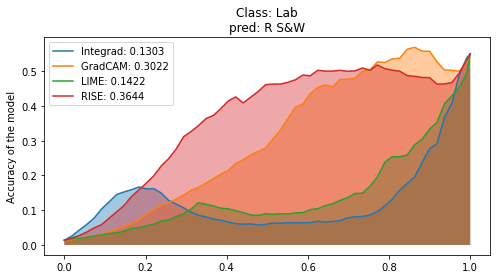

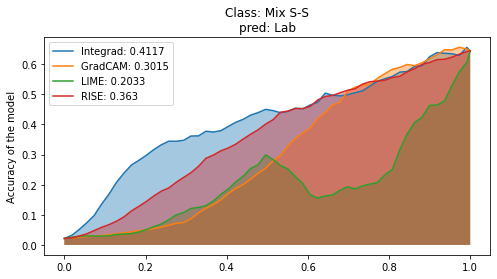

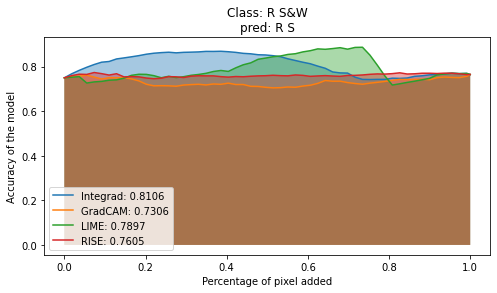

In [ ]:
for ii in range(0,max):
  cl = name_num_classe[ii]
  image = x_miss[ii:ii+1]
  y_int = metric_ADDED(image, 99, intgrad_pt_score[ii,cl,:], rgb=False)
  y_lime = metric_ADDED(image, 99, lime_score[ii,:], rgb=False)
  y_rise = metric_ADDED(image, 99, rise_score[ii,:], rgb=False)
  y_gradCAM = metric_ADDED(image, 99, gradcam_pt_score[ii,cl,:], rgb=False)
  x = np.arange(len(y_lime))*step/(99*99)
  x[-1] = 1.0
  

  plt.figure(figsize=(8, 4))
  plt.title('Class: '+ name[ii] + '\n' + 'pred: '+ name_predict[ii])
  for nome, y in zip(['Integrad','GradCAM','LIME','RISE'],[y_int,y_gradCAM, y_lime,y_rise]):
      plt.plot(x, y, label=f'{nome}: {np.round(auc(x, y),4)}')
      plt.fill_between(x, y, alpha=0.4)
  if ii == 2:
    plt.xlabel('Percentage of pixel added')
  plt.ylabel('Accuracy of the model')
  plt.legend();